# Logistic regression

## Classification with one continuous variable

+ Consider our example MRI data
+ Suppose now that we want to predict the gold standard from the FLAIR values. 

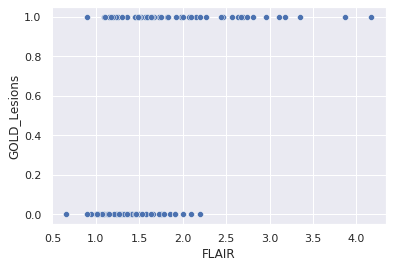

In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.linear_model as lm
sns.set()
dat = pd.read_csv("https://raw.githubusercontent.com/bcaffo/ds4bme_intro/master/data/oasis.csv")
sns.scatterplot(x = 'FLAIR', y = 'GOLD_Lesions', data = dat);

## How to fit

+ Fitting a line seems weird, since the outcome can only be 0 or 1. 
+ A line would allow for arbitrarily small or large predictions. 
+ Similiarly, forcing the prediction to be exactly 0 or 1 leads to difficult optimization problems. 
+ Instead consider modeling

$$
P(Y_i = 1 ~|~ X_i)
$$

+ $Y_i$ is the gold standard value for voxel $i$
+ $X_i$ is the FLAIR value for voxel $i$

## Modeling probabilities

+ We need a probability model that lives between 0 and 1
+ Log odds (logit) models convert probabliities to 
$$
\eta = \mathrm{logit}(p) = \log\{p / (1 - p)\}
$$
+ Here $p$ is the probability and $O = p/(1-p)$ is called the **odds**
+ Note, you can go backwards from odds to probability with the function 

$$p = O / (1 + O)$$

## Why use odds?

+ There are specific study designs where odds make more sense than probabilities, particularly retrospective ones. 
+ Odds are unique in binomial models where they work out to be particularly tractible 
+ Odds have a unique gambling interpretation in that they give the ratio of a  one dollar risk to the return in a fair bet. 

## Logit models

+ We model the log of the odds as linear in the covariate, resulting in a technique called **logistic regression**.

$$
\eta = \mathrm{logit}\left\{ P(Y = 1 ~|~ X) \right\}
= \beta_0 + \beta_1 X.
$$

+ $e^\beta_1$ has the nice interpretation of the odds ratio associated with a one unit change in $X$

## Implied model on the probability scale

$$
p = \frac{e^{\eta}}{1 + e^\eta} = \frac{1}{1 + e^{-\eta}}.
$$

+ This is sometimes called the **expit** function or **sigmoid**

## Optimization

+ We can minimize the cross entropy to obtain an estimate for $\beta_0$ and $\beta_1$

$$
-\sum_{i=1}^n \left[Y_i \log\{P(Y_i = 1 ~|~ X_i)\} + (1 - Y_i) \log\{1 - P(Y_i = 1 ~|~ X_i)\}\right].
$$

+ This function has the interpretation of being the negative of the log of the probabilities assuming the $Y_i$ are independent

+ Plugging our logit model in, the cross entropy now looks like

$$
-\sum_{i=1}^n \left[
  Y_i \eta_i + \log\left\{\frac{1}{1 + e^\eta_i} \right\} \right].
$$

# Back to the data analysis

Let's now fit the model. Again we're going to split into training and test data. But, now we're not going to do it manually since we have to load a library that has a function to do this.

In [12]:
# Preparing the data

x = dat[['FLAIR']]
y = dat.GOLD_Lesions
trainFraction = .75

## Once again hold out some data
sample = np.random.uniform(size = 100) < trainFraction
xtrain = x[ sample]
ytrain = y[ sample]
xtest =  x[~sample]
ytest =  y[~sample]

In [13]:
# Fitting 

lr = lm.LogisticRegression(fit_intercept=True, penalty='none')
fit = lr.fit(xtrain, ytrain)

# Inspecting the results

In [14]:
beta0, beta1 = [fit.intercept_[0], fit.coef_[0][0]]
[beta0, beta1]

[-3.623754342563001, 2.2095218958965694]

<AxesSubplot:xlabel='FLAIR', ylabel='GOLD_Lesions'>

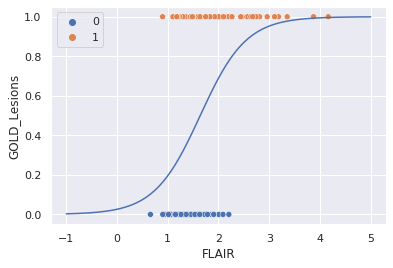

In [15]:
## Plotting

n = 1000
xplot = np.linspace(-1, 5, n)
eta = beta0 + beta1 * xplot
p = 1 / (1 + np.exp(-eta))

sns.scatterplot(x = 'FLAIR', y = 'GOLD_Lesions', data = dat, hue = 'GOLD_Lesions')
sns.lineplot(x = xplot, y =  p)

# Evaluating prediction performance on the test set

In [16]:
## This predicts the classes using a 50% probability cutoff
yhat_test = fit.predict(xtest)

## double checking that if you want
#all(yhat_test == (fit.predict_proba(xtest)[:, 1] > .5))

accuracy = np.mean(yhat_test == ytest)
sensitivity = np.mean(yhat_test[ytest == 1] == ytest[ytest == 1])
specificity = np.mean(yhat_test[ytest == 0] == ytest[ytest == 0])
np.round([accuracy, sensitivity, specificity], 3)


array([0.655, 0.533, 0.786])

In [17]:
from sklearn.metrics import accuracy_score, roc_curve, auc

ptest = fit.predict_proba(xtest)[:, 1]
fpr, tpr, thresholds = roc_curve(ytest, ptest)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2

<Figure size 432x288 with 0 Axes>

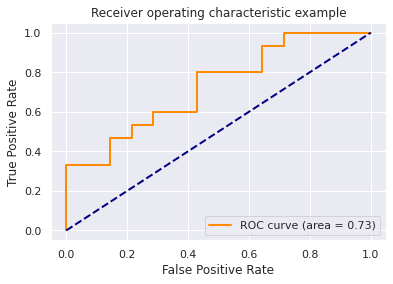

In [18]:
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()